# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime
#
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
#
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
#
pd.set_option('display.max_columns', None)

# Import csv

In [2]:
!ls ../../tresboncoin/data/master

master_data.csv                    master_with_fuzzy_and_cleaning.csv


In [3]:
data = pd.read_csv("../../tresboncoin/data/master/master_with_fuzzy_and_cleaning.csv")
data.shape

(42894, 23)

# Exploring data

## Basic exploration

In [4]:
data.head(3)

,url,uniq_id,brand,bike_year,mileage,bike_type,price,model,engine_size,date_scrapped,brand_db,model_db,model_submodel_db,year_db,category_db,engine_type_db,engine_size_db,power_db,torque_db,compression_db,cooling_system_db,dry_weight_db,power/weight_ratio_db
0,https://www.motoplanete.com/occasion-moto/3254...,motoplanete-32546,royalenfield,2003,9476.0,Routière & GT,2390.0,bullet,350.0,2021/06/04 - 22h19,enfield,bullet500,bullet500,2015.0,classic,single cylinder,499.0,26.1,40.9,8.5:1,Air,NaN,NaN
1,https://www.motoplanete.com/occasion-moto/4186...,motoplanete-41862,honda,2021,501.0,Trail,16599.0,africatwin,1100.0,2021/06/04 - 22h19,honda,africatwin,africatwin,2020.0,enduro / offroad,twin,1084.0,101.0,104.4,10.1:1,Liquid,NaN,NaN
2,https://www.motoplanete.com/occasion-moto/3732...,motoplanete-37320,gasgas,2021,300.0,Enduro,8590.0,ec,300.0,2021/06/04 - 22h19,gasgas,ec250,ec2504t,2010.0,enduro / offroad,single cylinder,249.3,NaN,NaN,NaN,Liquid,110.0,NaN


In [5]:
data.shape

(42894, 23)

In [6]:
data["category_db"].value_counts()

naked bike                   8161
scooter                      7944
sport                        6141
touring                      3871
sport touring                3448
enduro / offroad             3286
allround                     3263
classic                      2080
custom / cruiser             1991
super motard                 1558
unspecified category          451
cross / motocross             239
prototype / concept model     172
atv                           154
trial                          92
minibike, cross                39
minibike, sport                 4
Name: category_db, dtype: int64

## Duplicates

In [7]:
size_before = len(data)
data = data.drop_duplicates()
size_after = len(data)
print(str(size_before - size_after) + " duplicates were removed.")

0 duplicates were removed.


## Missing

In [8]:
100 * data.isnull().sum().sort_values(ascending=False)/len(data)

power/weight_ratio_db    51.548002
dry_weight_db            45.931832
bike_type                36.102951
torque_db                22.483331
compression_db           21.177787
engine_size              18.088777
power_db                 13.078752
date_scrapped             8.630578
cooling_system_db         5.564881
engine_size_db            0.389332
url                       0.013988
engine_type_db            0.009325
uniq_id                   0.000000
model_submodel_db         0.000000
year_db                   0.000000
category_db               0.000000
brand_db                  0.000000
model                     0.000000
price                     0.000000
mileage                   0.000000
bike_year                 0.000000
brand                     0.000000
model_db                  0.000000
dtype: float64

## Distribution and outliers

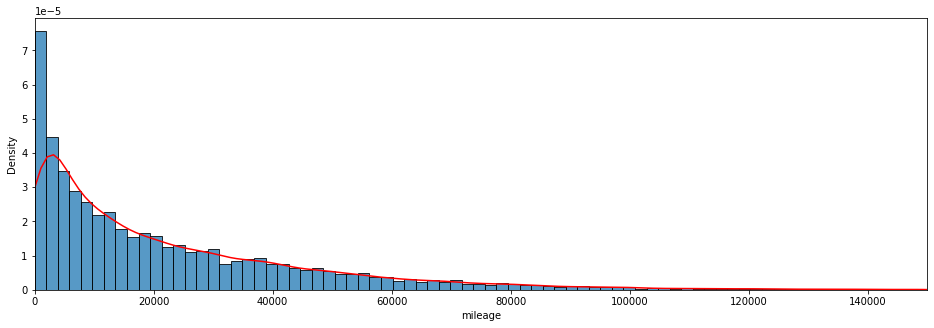

In [9]:
fig = plt.figure(figsize=(16, 5))
sns.histplot(data["mileage"], palette='Blues', stat='density', bins=100)
sns.kdeplot(data["mileage"], color='red')
plt.xlim(0, 150000);

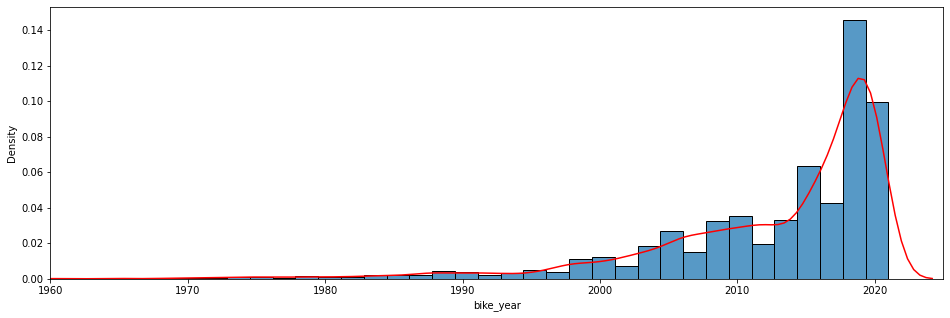

In [10]:
fig = plt.figure(figsize=(16, 5))
sns.histplot(data["bike_year"], palette='Blues', stat='density', bins=50)
sns.kdeplot(data["bike_year"], color='red')
plt.xlim(1960, 2025);

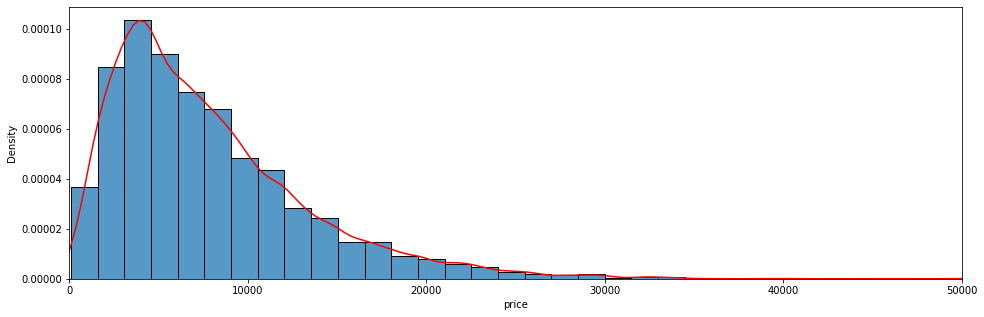

In [11]:
fig = plt.figure(figsize=(16, 5))
sns.histplot(data["price"], palette='Blues', stat='density', bins=40)
sns.kdeplot(data["price"], color='red')
plt.xlim(0, 50000);

(0.0, 93835.22808894335)

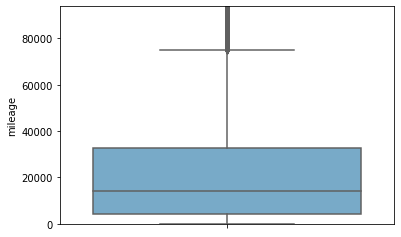

In [12]:
sns.boxplot(y=data["mileage"], palette="Blues");
plt.ylim(0, data["mileage"].mean() + 3*data["mileage"].std())

(1985.6693135718826, 2022.0)

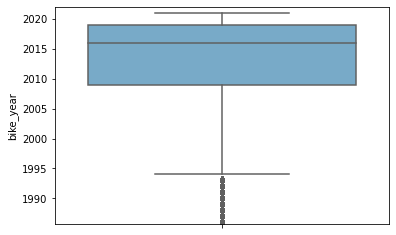

In [13]:
sns.boxplot(y=data["bike_year"], palette="Blues");
plt.ylim(-data["bike_year"].std()*3 + data["bike_year"].mean(), 2022)

(0.0, 24380.35565354605)

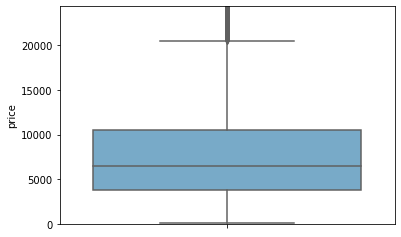

In [14]:
sns.boxplot(y=data["price"], palette="Blues");
plt.ylim(0, data["price"].mean() + 3*data["price"].std())

(49.0, 2102.5502709253296)

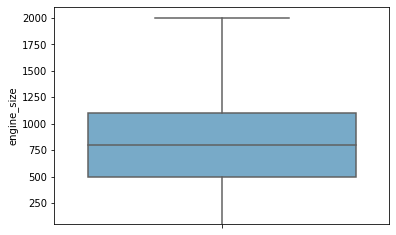

In [15]:
sns.boxplot(y=data["engine_size"], palette="Blues");
plt.ylim(49, data["engine_size"].mean() + 3*data["engine_size"].std())

# Cleaning

In [16]:
data.columns

Index(['url', 'uniq_id', 'brand', 'bike_year', 'mileage', 'bike_type', 'price',
       'model', 'engine_size', 'date_scrapped', 'brand_db', 'model_db',
       'model_submodel_db', 'year_db', 'category_db', 'engine_type_db',
       'engine_size_db', 'power_db', 'torque_db', 'compression_db',
       'cooling_system_db', 'dry_weight_db', 'power/weight_ratio_db'],
      dtype='object')

In [19]:
data = data[(data["bike_year"]>=(-data["bike_year"].std()*3 + data["bike_year"].mean())) & (data["bike_year"]<=2022)]
data = data[(data["mileage"]>=1000) & (data["mileage"]<=(data["mileage"].mean() + 3*data["mileage"].std()))]
data = data[(data["price"]>=1000) & (data["price"]<(data["price"].mean() + 3*data["price"].std()))]
data = data[(data["engine_size"]>=49) & (data["engine_size"]<(data["engine_size"].mean() + 3*data["engine_size"].std()))]

In [20]:
def km_per_year(km, bike_year):
    if (datetime.now().year - bike_year) == 0:
        return km
    return km / (datetime.now().year - bike_year)

In [21]:
#data.drop(['url', 'uniq_id', 'model_db', 'brand', "model", "brand_db"], axis=1, inplace=True)
data['km/year'] = data.apply(lambda x: km_per_year(x['mileage'], x['bike_year']), axis=1)

In [22]:
data.head(1)

,url,uniq_id,brand,bike_year,mileage,bike_type,price,model,engine_size,date_scrapped,brand_db,model_db,model_submodel_db,year_db,category_db,engine_type_db,engine_size_db,power_db,torque_db,compression_db,cooling_system_db,dry_weight_db,power/weight_ratio_db,km/year
0,https://www.motoplanete.com/occasion-moto/3254...,motoplanete-32546,royalenfield,2003,9476.0,Routière & GT,2390.0,bullet,350.0,2021/06/04 - 22h19,enfield,bullet500,bullet500,2015.0,classic,single cylinder,499.0,26.1,40.9,8.5:1,Air,NaN,NaN,526.444444



# Preparing model inputs

In [23]:
pd.DataFrame(data["brand_db"].value_counts()).shape

(95, 1)

In [69]:
data_saved = data.copy()

In [70]:
print(data.shape)
data = data[~data["category_db"].isnull()]
print(data.shape)

(28667, 24)
(28667, 24)


In [25]:
data_reduced = data[data["brand_db"].isin(list(pd.DataFrame(data["brand_db"].value_counts())[0:50].index))]

In [71]:
X = data_reduced.copy()[['brand_db', 'bike_year','mileage','engine_size','km/year', "category_db"]]
X.dropna(inplace=True)
y = data_reduced["price"]
X.shape

(28588, 6)

In [72]:
100 * X.isnull().sum().sort_values(ascending=False)/len(X)

brand_db       0.0
bike_year      0.0
mileage        0.0
engine_size    0.0
km/year        0.0
category_db    0.0
dtype: float64

# Pipelines

In [73]:
pipe_multiclass = Pipeline([
    ('encoder', OneHotEncoder(sparse=False, handle_unknown="ignore"))
])

In [57]:
list(X.columns)

['brand_db', 'bike_year', 'mileage', 'engine_size', 'km/year']

In [74]:
# applying encoder
encoder = ColumnTransformer([
    ('textual', pipe_multiclass, ["brand_db", "category_db"])
], remainder='passthrough')

In [75]:
# full preprocessor pipeline
preprocessor = Pipeline([("encoder", encoder),
                         ('scaler', MinMaxScaler())])

In [76]:
#output_pipe_columns = ["category_db_dual sport", "category_db_off-road", "category_db_scooter", "category_db_street", 'bike_year', 'mileage', 'km/year']

In [77]:
#X_train_scaled = pd.DataFrame(preprocessor.fit_transform(X), columns=output_pipe_columns)
#X_train_scaled.tail()

In [78]:
final_pipeline_ETR = Pipeline([
                          ("preprocessor", preprocessor),
                          ('model', ExtraTreesRegressor())
                         ])

In [79]:
final_pipeline_KNN = Pipeline([
                          ("preprocessor", preprocessor),
                          ('model', KNeighborsRegressor(n_neighbors=2))
                         ])

In [80]:
final_pipeline_SVR = Pipeline([
                          ("preprocessor", preprocessor),
                          ('model', SVR())
                         ])

In [81]:
final_pipeline_GBR = Pipeline([
                          ("preprocessor", preprocessor),
                          ('model', GradientBoostingRegressor())
                         ])

In [82]:
def custom_rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))
rmse = make_scorer(custom_rmse, greater_is_better=False)

# Baseline score

## Extra tree regressor

In [83]:
baseline = cross_validate(final_pipeline_ETR,
                          X,
                          y,
                          scoring={"rmse": rmse, "r2": "r2"},
                          cv=3)
baseline_r2 = baseline['test_r2'].mean()
baseline_rmse = -baseline['test_rmse'].mean()

In [84]:
print(baseline_r2, baseline_rmse)

0.8908796070092864 1492.400366952205


## KNN regressor

In [43]:
baseline_KNN = cross_validate(final_pipeline_KNN,
                          X,
                          y,
                          scoring={"rmse": rmse, "r2": "r2"},
                          cv=3)
baseline_KNN_r2 = baseline_KNN['test_r2'].mean()
baseline_KNN_rmse = -baseline_KNN['test_rmse'].mean()

In [44]:
print(baseline_KNN_r2, baseline_KNN_rmse)

0.8028674097899353 1983.5634746400744


## SVR

In [ ]:
baseline_SVR = cross_validate(final_pipeline_SVR,
                          X,
                          y,
                          scoring={"rmse": rmse, "r2": "r2"},
                          cv=3)
baseline_SVR_r2 = baseline_SVR['test_r2'].mean()
baseline_SVR_rmse = -baseline_SVR['test_rmse'].mean()

In [ ]:
print(baseline_SVR_r2, baseline_SVR_rmse)

# Optimized score

## Extra tree regressor

In [46]:
######################################################
# extra tree regressor parameters
######################################################
grid_ETR = {'model__max_depth': stats.randint(1, 1000),
            'model__min_samples_split': [2, 4, 6, 8, 10],
            "preprocessor__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]
            }
params_ETR = {"random_grid_search": grid_ETR,
              "model": ExtraTreesRegressor()}
######################################################

In [47]:
model_optimized_ETR = RandomizedSearchCV(final_pipeline_ETR,
                                         grid_ETR,
                                         scoring="r2",
                                         n_iter=10,
                                         cv=3,
                                         n_jobs=-1,
                                         verbose=1)
model_optimized_ETR.fit(X, y)
optimized_ETR_r2 = model_optimized_ETR.best_score_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/victor/.pyenv/versions/3.9.1/envs/tresboncoin/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [48]:
print(optimized_ETR_r2)

0.8943015249235691


In [49]:
model_optimized_ETR.best_params_

{'model__max_depth': 121,
 'model__min_samples_split': 6,
 'preprocessor__scaler': RobustScaler()}

## KNN regressor

In [72]:
######################################################
# KNN model
######################################################
grid_KNN = {'model__n_neighbors': stats.randint(1, 50),
            "preprocessor__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]
            }
params_KNN = {"random_grid_search": grid_KNN,
              "model": KNeighborsRegressor()}
######################################################

In [85]:
model_optimized_KNN = RandomizedSearchCV(final_pipeline_KNN,
                                         grid_KNN,
                                         scoring="r2",
                                         n_iter=1,
                                         cv=3,
                                         n_jobs=-1,
                                         verbose=1)
model_optimized_KNN.fit(X, y)
optimized_KNN_r2 = model_optimized_KNN.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [86]:
print(optimized_KNN_r2)

0.7807100905565928


In [63]:
model_optimized_KNN.best_params_

{'model__n_neighbors': 15, 'preprocessor__scaler': MinMaxScaler()}

## SVR

In [91]:
######################################################
# svr parameters
######################################################
grid_SVR = {'model__degree': stats.randint(1, 5),
            'model__kernel': ["linear", "poly", "rbf", "sigmoid"],
            'model__C': stats.loguniform(0.001, 2),
            "preprocessor__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]
            }
params_SVR = {"random_grid_search": grid_SVR,
              "model": SVR()}
######################################################

In [92]:
model_optimized_SVR = RandomizedSearchCV(final_pipeline_SVR,
                                         grid_SVR,
                                         scoring="r2",
                                         n_iter=1,
                                         cv=3,
                                         n_jobs=-1,
                                         verbose=1)
model_optimized_SVR.fit(X, y)
optimized_SVR_r2 = model_optimized_SVR.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


In [95]:
model_optimized_SVR.best_params_

{'model__C': 0.0033257718453115204,
 'model__degree': 1,
 'model__kernel': 'sigmoid',
 'preprocessor__scaler': MinMaxScaler()}

In [93]:
print(optimized_SVR_r2)

-0.15802040477269194


## Gradient Boosting Regressor

In [50]:
######################################################
# GradientBoostingRegressor model
######################################################
grid_GBR = {#'model__loss': ["ls", "lad", "huber", "quantile"],
            'model__learning_rate': stats.loguniform(0.001, 10),
            'model__n_estimators': stats.randint(1, 300),
            "preprocessor__scaler": [StandardScaler(), RobustScaler(), MinMaxScaler()]
           }
#
params_GBR = {"random_grid_search": grid_GBR,
              "model": GradientBoostingRegressor()}
######################################################

In [51]:
model_optimized_GBR = RandomizedSearchCV(final_pipeline_GBR,
                                         grid_GBR,
                                         scoring="r2",
                                         n_iter=20,
                                         cv=3,
                                         n_jobs=-1,
                                         verbose=1)
model_optimized_GBR.fit(X, y)
optimized_GBR_r2 = model_optimized_GBR.best_score_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/victor/.pyenv/versions/3.9.1/envs/tresboncoin/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [            -inf  8.51040481e-001 -1.29914027e+065  8.62803699e-001
  5.10997148e-001 -7.22218637e+004  8.50704821e-001  3.72084213e-001
 -7.98406452e+166  8.51225334e-001  8.22189791e-001  8.14026158e-001
  8.34598263e-001             -inf  7.86164471e-001  8.55042814e-001
  6.15229873e-001  8.35163472e-001  8.68110595e-001 -7.79805153e+125]
  warnings.warn(
/Users/victor/.pyenv/versions/3.9.1/envs/tresboncoin/lib/python3.9/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/Users/victor/.pyenv/versions/3.9.1/envs/tresboncoin/lib/python3.9/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: overflow encountered in square
  array_stds = np.sqrt(np.average((array -


In [52]:
print(optimized_GBR_r2)

0.8681105951075082


In [53]:
model_optimized_GBR.best_params_

{'model__learning_rate': 0.3269108042683677,
 'model__n_estimators': 256,
 'preprocessor__scaler': RobustScaler()}

# Best Baseline

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor

In [110]:
regressors = [LinearRegression(), 
              SGDRegressor(), 
              KernelRidge(), 
              ElasticNet(), 
              BayesianRidge(), 
              GradientBoostingRegressor()]

In [109]:
for K in regressors:
    final_pipeline_search = Pipeline([
                              ("preprocessor", preprocessor),
                              ('model', K)
                             ])
    baseline_search = cross_validate(final_pipeline_search,
                          X,
                          y,
                          scoring={"rmse": rmse, "r2": "r2"},
                          cv=3)
    baseline_search_r2 = baseline_search['test_r2'].mean()
    baseline_search_rmse = -baseline_search['test_rmse'].mean()
    print(baseline_search_r2, baseline_search_rmse)

-2.981934706933186e+20 47534801528775.02
0.7196672701238311 2529.2748972812933
0.7197096356638645 2529.0897835969386
0.05011349634909912 4658.225200267394
0.7196624394590557 2529.220540732524
0.8347656620473357 1939.389775476692


# Predict

In [188]:
list(X.columns)

['brand_db', 'bike_year', 'mileage', 'engine_size', 'km/year']

In [191]:
X_pred = pd.DataFrame({"brand_db": ["yamaha"],
                       "bike_year": [2019],
                       "mileage": [10000],
                       "engine_size": [250],
                       "km/year": [249],
                       })

In [192]:
model_optimized.best_estimator_.predict(X_pred)

array([6173.1865])